# Classifying SNe

`Authors: Carolina Núñez, Vicente Pedreros, Antonio Vitalic`

The Dark Energy Science Collaboration released a new dataset with simulated light curves from LSST, including many classes of transient and persistent sources, including light curves and host information: [training set](https://portal.nersc.gov/cfs/lsst/DESC_TD_PUBLIC/ELASTICC/#trainingset)

In this project you are asked to build a classifier that can discriminate between the three classes of SNe: SNII (SNII-Templates, SNII-HostXT_V19 and SNII-NMF), SNIa (SNIa-91bg, SNIa-SALT2 and SNIax) and SNIbc (SNIb+HostXT_V19, SNIb-Templates, SNIc+HostXT_V19, SNIc-Templates, SNIcBL+HostXT_V19).
You can use metadata and light curve information.


Basic libraries are imported. Note that `Table` is used to transform the fits files to a pandas dataframe

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import fnmatch, glob

# from google.colab import drive
# drive.mount('/content/drive/')

# Display all columns of pandas dataframe
pd.set_option('display.max_columns', None)

In [15]:
colors = {'u': 'b', 'g': 'g', 'r': 'r', 'i': 'orange', 'z': 'brown', 'Y': 'k'}

## Curating the data

The first thing to do is import the data. The function `to_df` will recieve the path to the first model of each class and return a dataframe. Note that the columns that will be used to classification are in the list `alert_name`.

In [16]:
head_filenames = fnmatch.filter(glob.glob('data_rn/*'), '*HEAD.FITS.gz')
# These are the classes that will be classified
classes = ['SNIa', 'SNIbc', 'SNII']

# The following columns are the ones that will be used for classification
alert_name = ['SNID', 'RA', 'DEC', 'NOBS', 'MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_SPECZ',
              'HOSTGAL_SPECZ_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_ZPHOT_Q000', 'HOSTGAL_ZPHOT_Q010', 'HOSTGAL_ZPHOT_Q020', 'HOSTGAL_ZPHOT_Q030',
              'HOSTGAL_ZPHOT_Q040', 'HOSTGAL_ZPHOT_Q050', 'HOSTGAL_ZPHOT_Q060', 'HOSTGAL_ZPHOT_Q070', 'HOSTGAL_ZPHOT_Q080', 'HOSTGAL_ZPHOT_Q090', 'HOSTGAL_ZPHOT_Q100',
              'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'HOSTGAL_MAGERR_u', 'HOSTGAL_MAGERR_g', 'HOSTGAL_MAGERR_r',
              'HOSTGAL_MAGERR_i', 'HOSTGAL_MAGERR_z', 'HOSTGAL_MAGERR_Y', 'HOSTGAL2_RA', 'HOSTGAL2_DEC', 'HOSTGAL2_SNSEP', 'HOSTGAL2_SPECZ', 'HOSTGAL2_SPECZ_ERR', 'HOSTGAL2_PHOTOZ',
              'HOSTGAL2_PHOTOZ_ERR', 'HOSTGAL2_ZPHOT_Q000', 'HOSTGAL2_ZPHOT_Q010', 'HOSTGAL2_ZPHOT_Q020', 'HOSTGAL2_ZPHOT_Q030',  'HOSTGAL2_ZPHOT_Q040', 'HOSTGAL2_ZPHOT_Q050',
              'HOSTGAL2_ZPHOT_Q060', 'HOSTGAL2_ZPHOT_Q070', 'HOSTGAL2_ZPHOT_Q080', 'HOSTGAL2_ZPHOT_Q090', 'HOSTGAL2_ZPHOT_Q100', 'HOSTGAL2_MAG_u', 'HOSTGAL2_MAG_g',
              'HOSTGAL2_MAG_r', 'HOSTGAL2_MAG_i', 'HOSTGAL2_MAG_z', 'HOSTGAL2_MAG_Y', 'HOSTGAL2_MAGERR_u', 'HOSTGAL2_MAGERR_g', 'HOSTGAL2_MAGERR_r', 'HOSTGAL2_MAGERR_i',
              'HOSTGAL2_MAGERR_z', 'HOSTGAL2_MAGERR_Y', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR']

In [17]:
def to_df(filename):
    """
    This function recieves a filename and will create a dataframe by using the HEAD's and PHOT's files.
    The columns corresponding to simulation information are droppped.
    """
    df_train = Table.read(filename, format='fits').to_pandas()
    for col in ['SNID', 'IAUC', 'SIM_MODEL_NAME', 'SIM_TYPE_NAME']:
        df_train[col] = df_train[col].apply(
            lambda row: row.decode("utf-8").strip())

    df_lc = Table.read(filename.replace("HEAD", "PHOT"),
                       format='fits').to_pandas()
    for col in ['BAND', 'FIELD']:
        df_lc[col] = df_lc[col].apply(lambda row: row.decode("utf-8").strip())

    # The data from HEAD and PHOT are grouped.
    df = df_train.groupby("SNID").apply(
        lambda df: df_lc.iloc[df.PTROBS_MIN.iloc[0]-1:df.PTROBS_MAX.iloc[0]-1]).reset_index()
    df = pd.merge(df_train, df, left_on='SNID', right_on='SNID')

    # Only alert_name columns are considered
    df = df[alert_name]

    subclass = filename.replace('_HEAD.FITS.gz', '').replace(
        'data_rn/', '')  # Name of the subclass
    # List of strings containing the name of the subclass
    subclasses = [subclass for x in range(len(df))]

    _class_ = subclass[:4]  # Name of the class
    # List of strings containing the name of the class
    classes = [_class_ for x in range(len(df))]

    # A column containing the class and subclass are added
    df.insert(0, 'SUBCLASS', subclasses)
    df.insert(0, 'CLASS', classes)
    df.replace(['SNIb', 'SNIc'], 'SNIbc', inplace=True)

    return df

In [18]:
dataframes = [to_df(filename) for filename in head_filenames]

df_train = pd.concat(dataframes)
df_train

,CLASS,SUBCLASS,SNID,RA,DEC,NOBS,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_ZPHOT_Q000,HOSTGAL_ZPHOT_Q010,HOSTGAL_ZPHOT_Q020,HOSTGAL_ZPHOT_Q030,HOSTGAL_ZPHOT_Q040,HOSTGAL_ZPHOT_Q050,HOSTGAL_ZPHOT_Q060,HOSTGAL_ZPHOT_Q070,HOSTGAL_ZPHOT_Q080,HOSTGAL_ZPHOT_Q090,HOSTGAL_ZPHOT_Q100,HOSTGAL_MAG_u,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAG_Y,HOSTGAL_MAGERR_u,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL_MAGERR_Y,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_ZPHOT_Q000,HOSTGAL2_ZPHOT_Q010,HOSTGAL2_ZPHOT_Q020,HOSTGAL2_ZPHOT_Q030,HOSTGAL2_ZPHOT_Q040,HOSTGAL2_ZPHOT_Q050,HOSTGAL2_ZPHOT_Q060,HOSTGAL2_ZPHOT_Q070,HOSTGAL2_ZPHOT_Q080,HOSTGAL2_ZPHOT_Q090,HOSTGAL2_ZPHOT_Q100,HOSTGAL2_MAG_u,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAG_Y,HOSTGAL2_MAGERR_u,HOSTGAL2_MAGERR_g,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL2_MAGERR_Y,MJD,BAND,FLUXCAL,FLUXCALERR
0,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60442.4130,i,-1.563279,11.344539
1,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60444.4280,r,3.731861,4.645030
2,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60457.4187,Y,-17.873014,42.014057
3,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60457.4293,z,12.042594,25.301315
4,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.3

In [25]:
df_train2 = df_train.copy()
df_train2.drop(df_train2[df_train2.NOBS < 50].index, inplace=True)

In [26]:
print(len(df_train.SNID.unique()))
print(len(df_train2.SNID.unique()))

23642
22992


In [27]:
df = df_train2[['SNID', 'CLASS', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR']].copy()
df.MJD = df.MJD.round(0).astype(int)
df

,SNID,CLASS,MJD,BAND,FLUXCAL,FLUXCALERR
33,31254142,SNII,60550,u,-18.278835,8.333675
34,31254142,SNII,60550,r,3.481718,3.379142
35,31254142,SNII,60550,i,2.467680,6.355485
36,31254142,SNII,60553,u,23.797745,10.453723
37,31254142,SNII,60553,g,-0.527714,3.756804
...,...,...,...,...,...,...
118810,15480123,SNIbc,60961,i,-10.518693,8.376203
118811,15480123,SNIbc,60961,z,8.501602,15.873994
118812,15480123,SNIbc,60967,r,1.206127,3.369061
118813,15480123,SNIbc,60967,i,-8.784276,3.759806


## Visualization of data

A count plot, 20 lightcurves per class and histograms are presented.

In [ ]:
ax = df.groupby('SNID').max().CLASS.value_counts().plot.bar()

In [100]:
def plot_lc(SNID, df, path=None):
    """
    Plots the lightcurves, generating a lightcurve (lc) for each band, but it shows
    all bands in one figure.
    """
    fig, ax = plt.subplots(figsize=(8, 3))
    for idx, c in enumerate(colors.keys()):
        mask = (df.SNID == str(SNID)) & (df.BAND == c)
        if mask.sum() > 0:
            ax.errorbar(df.loc[mask].MJD, df.loc[mask].FLUXCAL,
                        yerr=df.loc[mask].FLUXCALERR, color=list(colors.values())[idx], fmt='o', ms=3, lw=0, elinewidth=1, label=c)

    ax.set_xlabel('mjd')
    ax.set_ylabel('Flux')
    ax.legend()
    ax.set_title(str(SNID) + ' ' + df.loc[mask].iloc[0].CLASS)
    if path is not None:
        fig.savefig(path+'lc_'+SNID+'.png')

In [ ]:
np.random.seed(73)

snids_20sample = [list(df.loc[df.CLASS.isin([df.CLASS.unique()[i]])].sample(
    20).SNID) for i in range(len(df.CLASS.unique()))]

snids_20 = sum(snids_20sample, [])

In [ ]:
for snid in snids_20:
    plot_lc(str(snid), df, path='images/lightcurves/')
    plt.show()

In [ ]:
# Histograma de flujos de todos los datos
counts, bins = np.histogram(
    df.FLUXCAL.to_numpy(), bins=100, range=(-200, 200))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Flux histogram')

In [ ]:
# Flux Error Histogram
counts, bins = np.histogram(
    df.FLUXCALERR.to_numpy(), bins=50, range=(0, 100))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Flux error histogram')

In [ ]:
# SNR Histogram
counts, bins = np.histogram(df.FLUXCAL.to_numpy(
)/df.FLUXCALERR.to_numpy(), bins=50, range=(0, 30))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Signal to noise ratio histogram')

In [ ]:
# Number of observations Histogram

fig, ax = plt.subplots()
for c in list(colors.keys()):
    counts, bins = np.histogram(
        df_train.loc[df_train.BAND == c].NOBS.to_numpy(), bins=100)
    ax.hist(bins[:-1], bins, weights=counts, alpha=0.3)
plt.title('Number of observations histogram')

## Preprocessing 

In [28]:
# Dataframe containing peak in flux for each object

flux_max = df.groupby('SNID').FLUXCAL.idxmax()
df_maxflux = df.iloc[flux_max].reset_index(drop=True)
df_maxflux

,SNID,CLASS,MJD,BAND,FLUXCAL,FLUXCALERR
0,7833060,SNII,60928,z,-3.324038,21.137375
1,87771694,SNII,60666,i,-0.438283,5.751649
2,9040418,SNII,61136,Y,-3.375007,22.290045
3,21030638,SNII,60613,g,2.809989,1.694526
4,51254193,SNII,60579,i,25.354132,5.254216
...,...,...,...,...,...,...
22987,28490541,SNII,60465,u,24.133301,18.201540
22988,72449858,SNII,60641,r,17.279472,5.514685
22989,3265591,SNII,61244,i,9.812181,13.668275
22990,68079847,SNII,60565,i,5.985811,6.024142


# Pivot Table

In [29]:
df_pivot = pd.pivot_table(df, values=['FLUXCAL', 'FLUXCALERR'], index=['SNID','CLASS', 'MJD'], columns=['BAND'])
#df_pivot.reset_index(inplace=True)
df_pivot

FLUXCAL                                           \
BAND                          Y        g          i          r         u   
SNID     CLASS MJD                                                         
10003150 SNIa  61233        NaN      NaN        NaN  -1.414817       NaN   
               61242        NaN      NaN        NaN  12.562502       NaN   
               61252 -14.288333      NaN        NaN        NaN       NaN   
               61253  13.302554      NaN        NaN        NaN       NaN   
               61254        NaN      NaN   0.332748        NaN       NaN   
...                         ...      ...        ...        ...       ...   
998967   SNIbc 61117        NaN      NaN        NaN   6.190294 -3.885509   
               61119        NaN -5.10589   5.187583   3.482333       NaN   
               61125 -11.775251      NaN        NaN        NaN       NaN   
               61128        NaN      NaN  -9.718035        NaN       NaN   
               61129        NaN      NaN  13.574255        NaN       NaN   

                                FLUXCALERR                                 \
BAND                          z          Y         g          i         r   
SNID     CLASS MJD                                                          
10003150 SNIa  61233        NaN        NaN       NaN        NaN  5.866288   
               61242        NaN        NaN       NaN        NaN  7.587483   
               61252  -6.247399  12.295647       NaN        NaN       NaN   
               61253  -3.064858  41.449608       NaN        NaN       NaN   
               61254 -14.575239        NaN       NaN  29.143602       NaN   
...                         ...        ...       ...        ...       ...   
998967   SNIbc 61117        NaN        NaN       NaN        NaN  5.263705   
               61119        NaN        NaN  3.509605   5.897748  2.940974   
               61125 -24.773096  23.805344       NaN        NaN       NaN   
               61128        NaN        NaN       NaN   9.448407       NaN   
               61129        NaN        NaN       NaN  10.842972       NaN   

                                           
BAND                         u          z  
SNID     CLASS MJD                         
10003150 SNIa  61233       NaN        NaN  
               61242       NaN        NaN  
               61252       NaN  10.676776  
               61253       NaN  21.993198  
               61254       NaN  33.441147  
...                        ...        ...  
998967   SNIbc 61117  9.244418        NaN  
               61119       NaN        NaN  
               61125       NaN  11.694359  
               61128       NaN        NaN  
               61129       NaN        NaN  

[1318561 rows x 12 columns]

In [30]:
df_pivot.columns = df_pivot.columns.droplevel(0)
df_pivot = df_pivot.reset_index().rename_axis(None, axis=1)

In [31]:
cols_f = ['F_Y', 'F_g', 'F_i', 'F_r', 'F_u', 'F_z']
cols_err = ['E_Y', 'E_g', 'E_i', 'E_r', 'E_u', 'E_z']

col = np.concatenate([cols_f, cols_err])
col

array(['F_Y', 'F_g', 'F_i', 'F_r', 'F_u', 'F_z', 'E_Y', 'E_g', 'E_i',
       'E_r', 'E_u', 'E_z'], dtype='<U3')

In [32]:
u = ['SNID', 'CLASS', 'MJD']
df_pivot.columns = np.concatenate([u, col])

In [33]:
df_pivot

,SNID,CLASS,MJD,F_Y,F_g,F_i,F_r,F_u,F_z,E_Y,E_g,E_i,E_r,E_u,E_z
0,10003150,SNIa,61233,NaN,NaN,NaN,-1.414817,NaN,NaN,NaN,NaN,NaN,5.866288,NaN,NaN
1,10003150,SNIa,61242,NaN,NaN,NaN,12.562502,NaN,NaN,NaN,NaN,NaN,7.587483,NaN,NaN
2,10003150,SNIa,61252,-14.288333,NaN,NaN,NaN,NaN,-6.247399,12.295647,NaN,NaN,NaN,NaN,10.676776
3,10003150,SNIa,61253,13.302554,NaN,NaN,NaN,NaN,-3.064858,41.449608,NaN,NaN,NaN,NaN,21.993198
4,10003150,SNIa,61254,NaN,NaN,0.332748,NaN,NaN,-14.575239,NaN,NaN,29.143602,NaN,NaN,33.441147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318556,998967,SNIbc,61117,NaN,NaN,NaN,6.190294,-3.885509,NaN,NaN,NaN,NaN,5.263705,9.244418,NaN
1318557,998967,SNIbc,61119,NaN,-5.10589,5.187583,3.482333,NaN,NaN,NaN,3.509605,5.897748,2.940974,NaN,NaN
1318558,998967,SNIbc,61125,-11.775251,NaN,NaN,NaN,NaN,-24.773096,23.805344,NaN,NaN,NaN,NaN,11.694359
1318559,998967,SNIbc,61128,NaN,NaN,-9.718035,NaN,NaN,NaN,NaN,NaN,9.448407,NaN,NaN,NaN


In [34]:
df_pivot.interpolate(limit=20, limit_direction='both', inplace=True)

In [35]:
df_pivot

,SNID,CLASS,MJD,F_Y,F_g,F_i,F_r,F_u,F_z,E_Y,E_g,E_i,E_r,E_u,E_z
0,10003150,SNIa,61233,-14.288333,6.327947,0.332748,-1.414817,8.475088,-6.247399,12.295647,4.982406,29.143602,5.866288,7.261147,10.676776
1,10003150,SNIa,61242,-14.288333,6.327947,0.332748,12.562502,8.475088,-6.247399,12.295647,4.982406,29.143602,7.587483,7.261147,10.676776
2,10003150,SNIa,61252,-14.288333,6.327947,0.332748,8.540399,8.475088,-6.247399,12.295647,4.982406,29.143602,7.858711,7.261147,10.676776
3,10003150,SNIa,61253,13.302554,6.327947,0.332748,4.518295,8.475088,-3.064858,41.449608,4.982406,29.143602,8.129938,7.261147,21.993198
4,10003150,SNIa,61254,24.177702,6.327947,0.332748,0.496191,8.475088,-14.575239,39.362045,4.982406,29.143602,8.401166,7.261147,33.441147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318556,998967,SNIbc,61117,22.310989,-4.009136,1.509835,6.190294,-3.885509,-10.292803,34.296665,3.192965,6.576092,5.263705,9.244418,14.980350
1318557,998967,SNIbc,61119,5.267869,-5.105890,5.187583,3.482333,-3.885509,-17.532949,29.051004,3.509605,5.897748,2.940974,9.244418,13.337354
1318558,998967,SNIbc,61125,-11.775251,-5.105890,-2.265226,3.482333,-3.885509,-24.773096,23.805344,3.509605,7.673078,2.940974,9.244418,11.694359
1318559,998967,SNIbc,61128,-11.775251,-5.105890,-9.718035,3.482333,-3.885509,-24.773096,23.805344,3.509605,9.448407,2.940974,9.244418,11.694359


In [36]:
snids = df_pivot.SNID.unique()

In [37]:
corte = df_maxflux[['SNID', 'MJD']]
corte

,SNID,MJD
0,7833060,60928
1,87771694,60666
2,9040418,61136
3,21030638,60613
4,51254193,60579
...,...,...
22987,28490541,60465
22988,72449858,60641
22989,3265591,61244
22990,68079847,60565


Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')

In [57]:
for idx, snid  in enumerate(snids):
    mask = df_pivot.SNID == snid
    below_mjd = df_pivot.loc[mask].MJD < corte.MJD.iloc[idx]
    above_mjd = df_pivot.loc[mask].MJD > (corte.MJD.iloc[idx] + 200)

    df_pivot.drop(df_pivot.loc[mask][below_mjd].index, inplace=True)
    df_pivot.drop(df_pivot.loc[mask][above_mjd].index, inplace=True)

/tmp/ipykernel_8716/2125354185.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pivot.drop(df_pivot.loc[mask][above_mjd].index, inplace=True)


In [58]:
# Desde la medición del peak de flujo en la banda i, hasta 200 dias después, en pasos de a 4.

min_mjd = df_pivot.groupby('SNID').min().MJD  # mínimo mjd para cada objeto

df_mjd = pd.DataFrame(min_mjd, columns=df_pivot.columns, dtype='float64').drop('SNID', axis=1).reset_index()  # df contiene minimo mjd y snid
df_mjd

,SNID,CLASS,MJD,F_Y,F_g,F_i,F_r,F_u,F_z,E_Y,E_g,E_i,E_r,E_u,E_z
0,10010064,NaN,61220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10014400,NaN,60722.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1003343,NaN,60500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10039794,NaN,61102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10047302,NaN,60484.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13245,996682,NaN,61163.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13246,9975550,NaN,60494.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13247,9980180,NaN,60718.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13248,998406,NaN,60465.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# Each row is repeated 50 times
df_mjd = df_mjd.loc[df_mjd.index.repeat(50)]
df_mjd

,SNID,CLASS,MJD,F_Y,F_g,F_i,F_r,F_u,F_z,E_Y,E_g,E_i,E_r,E_u,E_z
0,10010064,NaN,61220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,10010064,NaN,61220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,10010064,NaN,61220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,10010064,NaN,61220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,10010064,NaN,61220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13249,9987542,NaN,60752.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13249,9987542,NaN,60752.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13249,9987542,NaN,60752.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13249,9987542,NaN,60752.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# This is a dataframe containing numbers between 0 and 196, in steps of 4
# df_add = pd.DataFrame( np.linspace(0, 196, 50), columns=['MJD'])

for snid in df_mjd.SNID.unique():
    mask = df_mjd.SNID == snid
    df_mjd.loc[mask, 'MJD'] = df_mjd.loc[mask].MJD + np.linspace(0, 196, 50)

In [61]:
df_mjd.reset_index(inplace=True, drop=True)
df_mjd

,SNID,CLASS,MJD,F_Y,F_g,F_i,F_r,F_u,F_z,E_Y,E_g,E_i,E_r,E_u,E_z
0,10010064,NaN,61220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10010064,NaN,61224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10010064,NaN,61228.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10010064,NaN,61232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10010064,NaN,61236.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662495,9987542,NaN,60932.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
662496,9987542,NaN,60936.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
662497,9987542,NaN,60940.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
662498,9987542,NaN,60944.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
# snids needs to be redefined
snids = df_mjd.SNID.unique()

## Building images (attempt 6x50)


In [78]:
# Tain test sets
from sklearn.model_selection import train_test_split

snids_train, snids_test = train_test_split(snids, test_size=.4, random_state=1)

In [79]:
# Labels vectors, train and test

df_class = df_pivot[['SNID', 'CLASS']].groupby(['SNID']).max().reset_index()
df_class

y_train = df_class.loc[df_class.SNID.isin(snids_train)].CLASS
y_test = df_class.loc[df_class.SNID.isin(snids_test)].CLASS

In [80]:
imgs_flux_train = []
imgs_flux_test = []

imgs_fluxerr_train = []
imgs_fluxerr_test = []

for snid in snids:
    df1 = df_mjd.loc[df_mjd.SNID == snid]
    df2 = df_pivot.loc[df_pivot.SNID == snid]
    for mjd in df2.MJD.to_numpy():
        if mjd not in df1.MJD.to_numpy():
            df2 = df2.drop(df2.loc[df2.MJD == mjd].index)
    df_combined = df1.combine_first(df2)
    df_combined = df_combined.drop_duplicates(subset='MJD', keep='last').sort_values('MJD')
    df_combined = df_combined.interpolate(limit=10, limit_direction='both')
    
    if snid in snids_train:
        imgs_flux_train.append(df_combined[cols_f].to_numpy().astype(float))
        imgs_fluxerr_train.append(df_combined[cols_err].to_numpy().astype(float))
    elif snid in snids_test:
        imgs_flux_test.append(df_combined[cols_f].to_numpy().astype(float))
        imgs_fluxerr_test.append(df_combined[cols_err].to_numpy().astype(float))

In [82]:
for idx in range(len(imgs_flux_train)):
    imgs_flux_train[idx] = np.transpose(np.nan_to_num(imgs_flux_train[idx]))
    imgs_fluxerr_train[idx] = np.transpose(np.nan_to_num(imgs_fluxerr_train[idx]))


for idx in range(len(imgs_flux_test)):
    imgs_flux_test[idx] = np.transpose(np.nan_to_num(imgs_flux_test[idx]))
    imgs_fluxerr_test[idx] = np.transpose(np.nan_to_num(imgs_fluxerr_test[idx]))

In [83]:
# Merging images so we have a big array, containing the two images for all objects

# X_train.shape = (nobj, 6 ,50, 2)

X_train = np.zeros((len(imgs_flux_train), 6, 50, 2))
X_test = np.zeros((len(imgs_flux_test), 6, 50, 2))

for i in range(len(X_train)):
    for j in range(6):
        for k in range(50):
            X_train[i][j][k][0] = imgs_flux_train[i][j][k]
            X_train[i][j][k][1] = imgs_fluxerr_train[i][j][k]

for i in range(len(X_test)):
    for j in range(6):
        for k in range(50):
            X_test[i][j][k][0] = imgs_flux_test[i][j][k]
            X_test[i][j][k][1] = imgs_fluxerr_test[i][j][k]

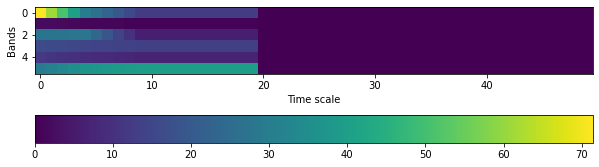

In [98]:
plt.figure(figsize=(10,5))
plt.imshow(imgs_flux_train[4501])
plt.colorbar(location='bottom')
plt.ylabel('Bands')
plt.xlabel('Time scale')
plt.show()


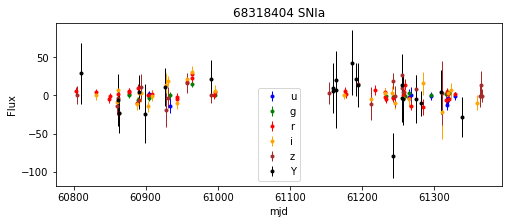

In [103]:
plot_lc(snids_train[4501], df_train)

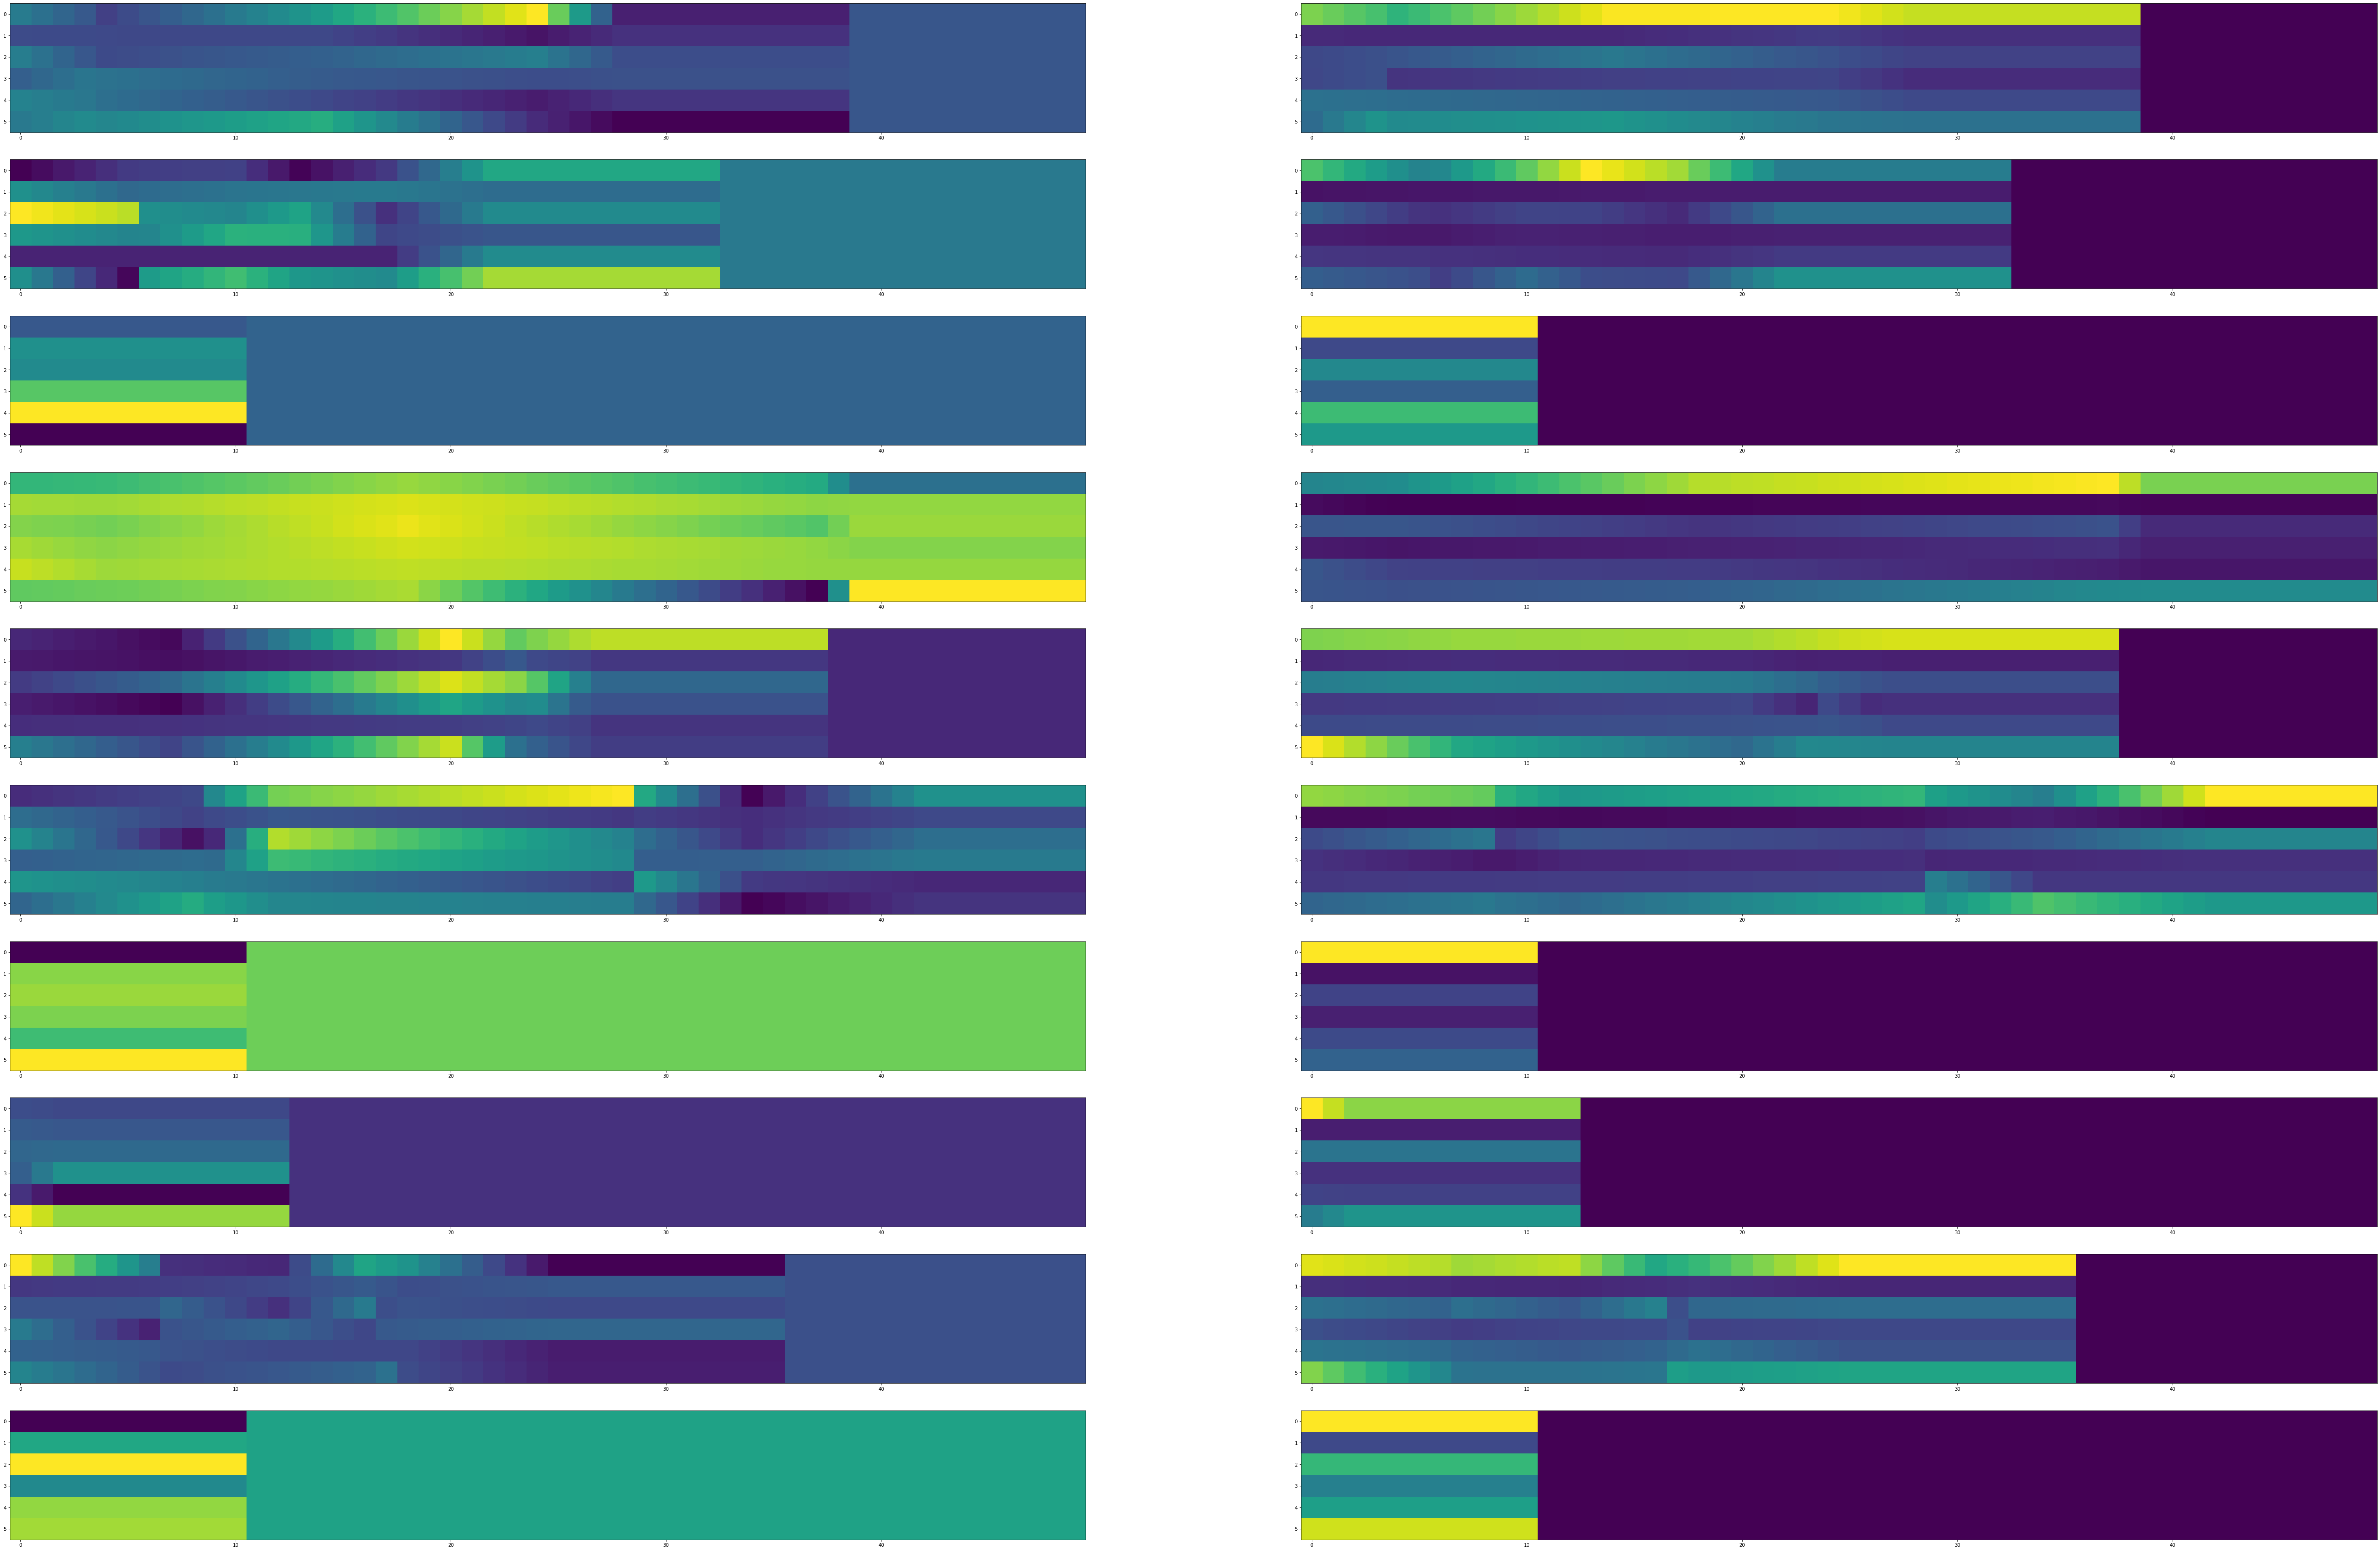

In [88]:
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(90,60))

for i in range(10):
    ax[i, 0].imshow(imgs_flux_train[i])
    ax[i, 1].imshow(imgs_fluxerr_train[i])

In [104]:
imgs = {'X_train': X_train, 'X_test': X_test, 'y_test': y_test, 'y_train': y_train}

# Saving the arrays. Note that the reshape is done since a 3D array can't be stored

for img in imgs.keys():
    try:
        np.savetxt(img + '.csv', imgs[img].reshape(imgs[img].shape[0], -1))
    except:
        np.savetxt(img + '.csv', imgs[img], fmt='%s')

## Building images

The goal of this section is to build images so a Neural Network can perform classification.

Images of 6 x 30 will be built for each object. Each row corresponds to a band and each column to an observation. In the case that an aobject has more than 30 observations, only the first 30 are considered.

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df.BAND = encoder.fit_transform(df.BAND)

color = np.sort(df.BAND.unique())
color

To split the data into training and test sets, the fact that the dataframe contains multiple rows for an object needs to be considered. So, the array containing the SNID's (`snids_array`) will be splitted into a train and test array.

In [ ]:
from sklearn.model_selection import train_test_split

snids = df.SNID.unique()

snids_train, snids_test = train_test_split(
    snids, test_size=0.4, random_state=1)

To build the label vectors $(y)$, a new dataframe called df_class is created, which contains the class corresponding to the object

In [ ]:
df_class = df[['SNID', 'CLASS']].groupby(['SNID']).max().reset_index()
df_class

In [ ]:
# X "dataframe" train and test sets
X_df_train = df.loc[df.SNID.isin(
    snids_train)].drop('CLASS', axis=1)
X_df_test = df.loc[df.SNID.isin(
    snids_test)].drop('CLASS', axis=1)

# Labels vectors train and test
y_train = df_class.loc[df_class.SNID.isin(snids_train)].CLASS
y_test = df_class.loc[df_class.SNID.isin(snids_test)].CLASS

# Label encoder for the labels vectors
le = LabelEncoder()
yt_train = le.fit_transform(y_train)
yt_test = le.fit_transform(y_test)

It's REALLY important to note this difference. In the future 23642 images will be built.

In [ ]:
print('Total elements in X_df: ', len(X_df_train) + len(X_df_test), '\n', 'Total elements in y: ', len(y_train) + len(y_test))

Images are built. The training set takes around 150m, while the test 100m. The images are stored as csv files and to load them see the Loading images section.

In [ ]:
X_train_time = np.zeros((len(snids_train), 6, 30))
X_train_flux = np.zeros((len(snids_train), 6, 30))
X_train_fluxerr = np.zeros((len(snids_train), 6, 30))

for i in range(len(snids_train)):
    for c in color:
        mask = (df.SNID == snids_train[i]) & (df.BAND == c)
        df_mask = df.loc[mask]

        times = df_mask.MJD.to_numpy()
        flux = df_mask.FLUXCAL.to_numpy()
        fluxerr = df_mask.FLUXCALERR.to_numpy()

        out_time = np.zeros(30)
        out_time[:len(times)] = times[:30]
        out_flux = np.zeros(30)
        out_flux[:len(flux)] = flux[:30]
        out_fluxerr = np.zeros(30)
        out_fluxerr[:len(fluxerr)] = fluxerr[:30]

        X_train_time[i][c] = out_time
        X_train_flux[i][c] = out_flux
        X_train_fluxerr[i][c] = out_fluxerr

In [ ]:
X_test_time = np.zeros((len(snids_test), 6, 30))
X_test_flux = np.zeros((len(snids_test), 6, 30))
X_test_fluxerr = np.zeros((len(snids_test), 6, 30))

for i in range(len(snids_test)):
    for c in color:
        mask = (df.SNID == snids_test[i]) & (df.BAND == c)
        df_mask = df.loc[mask]

        times = df_mask.MJD.to_numpy()
        flux = df_mask.FLUXCAL.to_numpy()
        fluxerr = df_mask.FLUXCALERR.to_numpy()

        out_time = np.zeros(30)
        out_time[:len(times)] = times[:30]
        out_flux = np.zeros(30)
        out_flux[:len(flux)] = flux[:30]
        out_fluxerr = np.zeros(30)
        out_fluxerr[:len(fluxerr)] = fluxerr[:30]

        X_test_time[i][c] = out_time
        X_test_flux[i][c] = out_flux
        X_test_fluxerr[i][c] = out_fluxerr

In [ ]:
imgs = {'time_train': X_train_time, 'flux_train': X_train_flux, 'fluxerr_train': X_train_fluxerr,
        'time_test': X_test_time, 'flux_test': X_test_flux, 'fluxerr_test': X_test_fluxerr,
        'y_test': y_test, 'y_train': y_train}

In [ ]:
# Saving the arrays. Note that the reshape is done since a 3D array can't be stored

for img in imgs.keys():
    try:
        np.savetxt(img + '.csv', imgs[img].reshape(imgs[img].shape[0], -1))
    except:
        np.savetxt(img + '.csv', imgs[img], fmt='%s')

The first ten images are presented

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(90, 60))

for i in range(10):
    for j in range(3):
        ax[i, 0].imshow(X_train_time[i])
        ax[i, 1].imshow(X_train_flux[i])
        ax[i, 2].imshow(X_train_fluxerr[i])


## Loading images

The next cell is to store the images in the dictionary `imgs_dict`

In [ ]:
imgs_name = ['time_train', 'flux_train', 'fluxerr_train', 'time_test', 'flux_test', 'fluxerr_test', 'y_test', 'y_train']

In [ ]:
# Loading the arrays
imgs_dict = {}
for idx, img in enumerate(imgs.keys()):
    if idx < 6:
        imgs_dict[img] = np.loadtxt(img+'.csv')
        imgs_dict[img] = imgs_dict[img].reshape(
            imgs_dict[img].shape[0], imgs_dict[img].shape[1] // 30, 30)
    else:
        imgs_dict[img] = np.loadtxt(img+'.csv', dtype='str')

#### Replacing zeros in the images

The median for each band will be replaced for the values that are 0.

In [ ]:
matrixes_list = ['time_train', 'flux_train', 'fluxerr_train', 'time_test', 'flux_test', 'fluxerr_test']

In [ ]:
for matrix in matrixes_list:
    for img in range(len(imgs_dict[matrix])):
        for row in imgs_dict[matrix][img]:
            median = np.median(row[row != 0])
            row[row == 0] = median

#### Checking "new" images

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(90, 60))

for i in range(10):
    for j in range(3):
        ax[i, j].imshow(imgs_dict[matrixes_list[j]][i])

In [ ]:
# Merging images so we have a big array, containing the three images for all objects
train_array = []

X_train = np.zeros((len(imgs_dict[matrixes_list[0]]), 6, 30, 3))
X_test = np.zeros((len(imgs_dict[matrixes_list[3]]), 6, 30, 3))

for i in range(len(imgs_dict[matrixes_list[0]])):
  for j in range(6):
    for k in range(30):
      for l in range(3):
          X_train[i][j][k][l] = imgs_dict[matrixes_list[l]][i][j][k]

for i in range(len(imgs_dict[matrixes_list[3]])):
  for j in range(6):
    for k in range(30):
      for l in range(3):
          X_test[i][j][k][l] = imgs_dict[matrixes_list[l+3]][i][j][k]